In [56]:
import pandas as pd
import numpy as np
import xgboost as xgb


In [139]:
df_en = pd.read_csv('english2_stats.csv', sep=',', header=0)
df_ko = pd.read_csv('korean_stats.csv', sep=',', header=0)
df_ta = pd.read_csv('tamil2_stats.csv', sep=',', header=0)

In [140]:
df_en['lang'] = 'en'
df_ko['lang'] = 'ko'
df_ta['lang'] = 'ta'

In [141]:
df = pd.concat([df_en, df_ko, df_ta], axis=0)

In [142]:
train_test_ratio = 0.5
train_valid_ratio = 0.5

train_size = int(len(df) * train_test_ratio * train_valid_ratio)
valid_size = int(len(df) * train_test_ratio * (1.0 - train_valid_ratio))
test_size = len(df) - train_size - valid_size

split = ['train'] * train_size + ['valid'] * valid_size + ['test'] * test_size
np.random.seed(43)
np.random.shuffle(split)

df['split'] = split

In [143]:
df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'valid']
df_test = df[df['split'] == 'test']

In [144]:
params = {
    "max_depth": 3,
    "objective": "multi:softmax",
    "num_class": 4,
    "eval_metric": "merror",
    "seed": 42,
}

In [149]:
# A
feats = ['PCT', 'PCC', 'PCV', 'VSA1', 'VSA2', 'VAI', 'FCR',
       'F2_ratio', 'jitter', 'apq', 'shimmer', 'ppq', 'HNR', 'nVB', 'perVB',
       'speaking_rate', 'articulation_rate', 'npause', 'phon_ratio',
       'pause_dur', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fmean',
       'Fstd', 'Fmin', 'Fmax', 'Franges', '%V', 'delta-V', 'delta-C',
       'varco-V', 'varco-C', 'Vrpvi', 'Crpvi', 'Vnpvi', 'Cnpvi']

bst = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(data=df_train[feats], label=df_train[['category']]),
    evals=[(xgb.DMatrix(data=df_valid[feats], label=df_valid[['category']]), "merror")],
    num_boost_round=200,
    verbose_eval=False,
)

for lang in df_test.lang.unique():
    print(lang, (bst.predict(xgb.DMatrix(data=df_test[df_test.lang == lang][feats])) == df_test[df_test.lang == lang]['category']).mean())
print((bst.predict(xgb.DMatrix(data=df_test[feats])) == df_test['category']).mean())

# scores = bst.get_score(importance_type='weight')
# plt.bar(range(len(scores)), list(scores.values()), tick_label=list(scores.keys()))
# plt.xticks(rotation=90)
# plt.show()

en 0.7632508833922261
ko 0.766497461928934
ta 0.9016393442622951
0.8814669286182056


en 0.7773851590106007


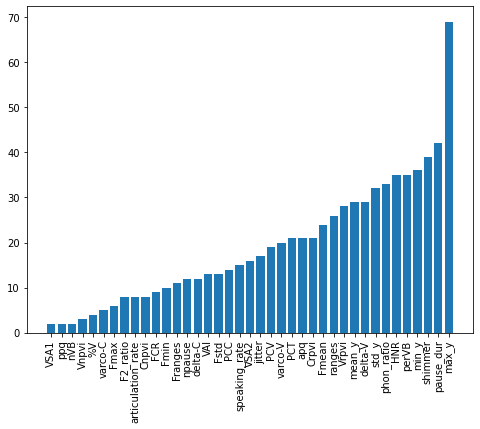

ko 0.7791878172588832


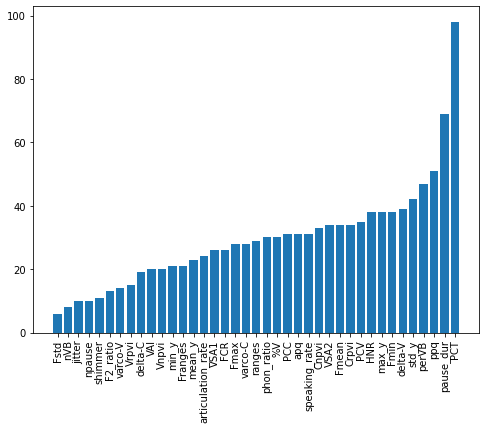

ta 0.9106045081967213


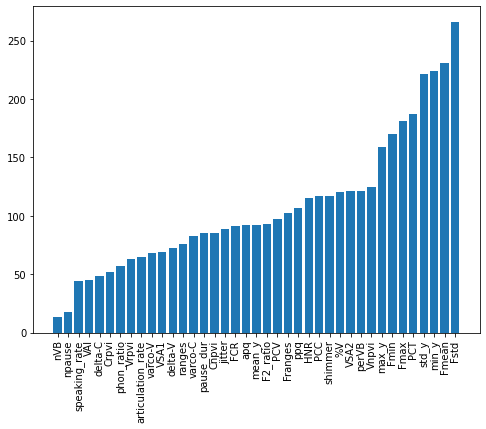

0.8910718183802663


In [166]:
# A-1
feats = ['PCT', 'PCC', 'PCV', 'VSA1', 'VSA2', 'VAI', 'FCR',
       'F2_ratio', 'jitter', 'apq', 'shimmer', 'ppq', 'HNR', 'nVB', 'perVB',
       'speaking_rate', 'articulation_rate', 'npause', 'phon_ratio',
       'pause_dur', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fmean',
       'Fstd', 'Fmin', 'Fmax', 'Franges', '%V', 'delta-V', 'delta-C',
       'varco-V', 'varco-C', 'Vrpvi', 'Crpvi', 'Vnpvi', 'Cnpvi']

preds = []
for lang in df.lang.unique():
    bst = xgb.train(
        params=params,
        dtrain=xgb.DMatrix(data=df_train[df_train.lang == lang][feats], label=df_train[df_train.lang == lang][['category']]),
        evals=[(xgb.DMatrix(data=df_valid[df_valid.lang == lang][feats], label=df_valid[df_valid.lang == lang][['category']]), "merror")],
        num_boost_round=200,
        verbose_eval=False,
    )
    lang_preds = bst.predict(xgb.DMatrix(data=df_test[df_test.lang == lang][feats])) == df_test[df_test.lang == lang]['category']
    print(lang, lang_preds.mean())

    preds.append(lang_preds)

    plt.figure(figsize=(8, 6))
    scores = bst.get_score(importance_type='weight')
    scores = dict(sorted(scores.items(), key=lambda i: i[1]))
    plt.bar(range(len(scores)), list(scores.values()), tick_label=list(scores.keys()))
    plt.xticks(rotation=90)
    plt.show()

print(np.concatenate(preds).mean())

In [150]:
# B
lang_feats = {
    'en': ['shimmer', 'apq', 'PCC', 'PCV', 'PCT', 'VSA2', 'VAI', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fstd'],
    'ko': ['PCC', 'PCV', 'PCT', 'pause_dur', 'phon_ratio', 'std_y', 'Fmax', 'delta-V'],
    'ta': ['PCC', 'PCV', 'PCT', 'VAI', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fstd', 'Fmin', 'Fmax', 'Franges', ]
}

preds = []
for lang in df.lang.unique():
    feats = lang_feats[lang]
    bst = xgb.train(
        params=params,
        dtrain=xgb.DMatrix(data=df_train[df_train.lang == lang][feats], label=df_train[df_train.lang == lang][['category']]),
        evals=[(xgb.DMatrix(data=df_valid[df_valid.lang == lang][feats], label=df_valid[df_valid.lang == lang][['category']]), "merror")],
        num_boost_round=200,
        verbose_eval=False,
    )

    lang_preds = bst.predict(xgb.DMatrix(data=df_test[df_test.lang == lang][feats])) == df_test[df_test.lang == lang]['category']
    print(lang, lang_preds.mean())

    preds.append(lang_preds)

print(np.concatenate(preds).mean())

en 0.7879858657243817
ko 0.7741116751269036
ta 0.8770491803278688
0.8626937349923598


In [151]:
# C
feats = ['PCC', 'PCV', 'PCT']

bst = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(data=df_train[feats], label=df_train[['category']]),
    evals=[(xgb.DMatrix(data=df_valid[feats], label=df_valid[['category']]), "merror")],
    num_boost_round=200,
    verbose_eval=False,
)

for lang in df_test.lang.unique():
    print(lang, (bst.predict(xgb.DMatrix(data=df_test[df_test.lang == lang][feats])) == df_test[df_test.lang == lang]['category']).mean())
print((bst.predict(xgb.DMatrix(data=df_test[feats])) == df_test['category']).mean())

en 0.3710247349823322
ko 0.6345177664974619
ta 0.6385758196721312
0.6216983191442916


In [152]:
# D
lang_feats = {
    'en': ['shimmer', 'apq', 'PCC', 'PCV', 'PCT', 'VSA2', 'VAI', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fstd'],
    'ko': ['PCC', 'PCV', 'PCT', 'pause_dur', 'phon_ratio', 'std_y', 'Fmax', 'delta-V'],
    'ta': ['PCC', 'PCV', 'PCT', 'VAI', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fstd', 'Fmin', 'Fmax', 'Franges', ]
}
feats = set()
for fs in lang_feats.values():
    feats = feats.union(set(fs))

bst = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(data=df_train[feats], label=df_train[['category']]),
    evals=[(xgb.DMatrix(data=df_valid[feats], label=df_valid[['category']]), "merror")],
    num_boost_round=200,
    verbose_eval=False,
)

for lang in df_test.lang.unique():
    print(lang, (bst.predict(xgb.DMatrix(data=df_test[df_test.lang == lang][feats])) == df_test[df_test.lang == lang]['category']).mean())
print((bst.predict(xgb.DMatrix(data=df_test[feats])) == df_test['category']).mean())

en 0.7879858657243817
ko 0.7614213197969543
ta 0.8983094262295082
0.8797205850251036


In [154]:
# E

def _remove_features(df):
    feats = ['PCT', 'PCC', 'PCV', 'VSA1', 'VSA2', 'VAI', 'FCR',
           'F2_ratio', 'jitter', 'apq', 'shimmer', 'ppq', 'HNR', 'nVB', 'perVB',
           'speaking_rate', 'articulation_rate', 'npause', 'phon_ratio',
           'pause_dur', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fmean',
           'Fstd', 'Fmin', 'Fmax', 'Franges', '%V', 'delta-V', 'delta-C',
           'varco-V', 'varco-C', 'Vrpvi', 'Crpvi', 'Vnpvi', 'Cnpvi']

    lang_feats = {
        'en': ['shimmer', 'apq', 'PCC', 'PCV', 'PCT', 'VSA2', 'VAI', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fstd'],
        'ko': ['PCC', 'PCV', 'PCT', 'pause_dur', 'phon_ratio', 'std_y', 'Fmax', 'delta-V'],
        'ta': ['PCC', 'PCV', 'PCT', 'VAI', 'mean_y', 'std_y', 'min_y', 'max_y', 'ranges', 'Fstd', 'Fmin', 'Fmax', 'Franges', ]
    }

    used_feats = set()
    for fs in lang_feats.values():
        used_feats = used_feats.union(set(fs))

    df = df.copy()
    for lang in df.lang.unique():
        remove_feats = set(feats) - set(lang_feats[lang])
        df.loc[df.lang == lang, list(remove_feats)] = np.NaN
    return df[used_feats]

bst = xgb.train(
    params=params,
    dtrain=xgb.DMatrix(data=_remove_features(df_train), label=df_train[['category']]),
    evals=[(xgb.DMatrix(data=_remove_features(df_valid), label=df_valid[['category']]), "merror")],
    num_boost_round=200,
    verbose_eval=False,
)

for lang in df_test.lang.unique():
    print(lang, (bst.predict(xgb.DMatrix(data=_remove_features(df_test[df_test.lang == lang]))) == df_test[df_test.lang == lang]['category']).mean())
print((bst.predict(xgb.DMatrix(data=_remove_features(df_test))) == df_test['category']).mean())

en 0.7985865724381626
ko 0.7461928934010152
ta 0.8757684426229508
0.8598559266535691
